In [1]:
!nvidia-smi

Tue Feb 18 14:36:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at : {}'.format(device_name))

Found GPU at : /device:GPU:0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pwd
%cd ./drive/My Drive/Colab Notebooks/UniverseDacon/
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)
sample_submission.describe()

/content
/content/drive/My Drive/Colab Notebooks/UniverseDacon


,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
count,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
train.describe()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199991.00000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,99995.00000,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,57732.57318,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,0.00000,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,49997.50000,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,99995.00000,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,149992.50000,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,199990.00000,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [5]:
test.describe()

,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,204995.000000,359.327805,20.987400,19.878440,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,19.083329,18.826624,20.715429,19.462021,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069
std,2889.493756,223.928862,2.111703,2.573890,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,1.633953,1.711790,2.807434,13.971203,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582
min,199991.000000,1.000000,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,12.688984,-8.455932,-98.181975,-1348.068776,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695
25%,202493.000000,174.000000,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,17.905253,17.610776,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685
50%,204995.000000,346.000000,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,19.180605,18.699819,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883
75%,207497.000000,525.000000,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,20.331848,20.119736,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902
max,209999.000000,1000.000000,37.681143,182.654452,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,31.146742,26.478564,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973


In [6]:
train_wo_type = train.drop(columns='type')
total = pd.concat([train_wo_type, test])
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 0 to 10008
Data columns (total 22 columns):
id            210000 non-null int64
fiberID       210000 non-null int64
psfMag_u      210000 non-null float64
psfMag_g      210000 non-null float64
psfMag_r      210000 non-null float64
psfMag_i      210000 non-null float64
psfMag_z      210000 non-null float64
fiberMag_u    210000 non-null float64
fiberMag_g    210000 non-null float64
fiberMag_r    210000 non-null float64
fiberMag_i    210000 non-null float64
fiberMag_z    210000 non-null float64
petroMag_u    210000 non-null float64
petroMag_g    210000 non-null float64
petroMag_r    210000 non-null float64
petroMag_i    210000 non-null float64
petroMag_z    210000 non-null float64
modelMag_u    210000 non-null float64
modelMag_g    210000 non-null float64
modelMag_r    210000 non-null float64
modelMag_i    210000 non-null float64
modelMag_z    210000 non-null float64
dtypes: float64(20), int64(2)
memory usage: 36.8 MB


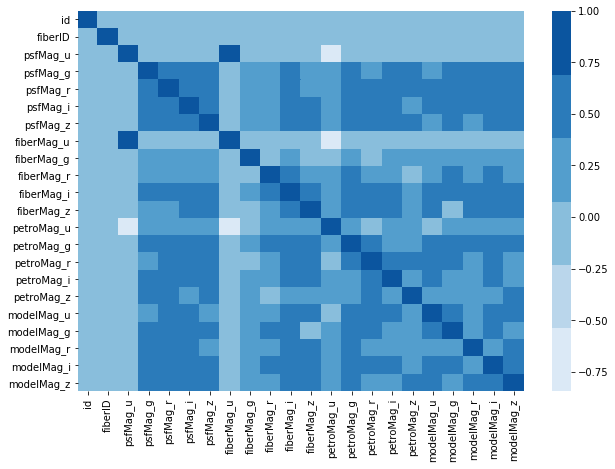

In [7]:
correlation = train.corr()
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10,7))
sns.heatmap(correlation, cmap=cmap)

In [8]:
from collections import Counter
def detect_outliers(df, n, features): 
  outlier_indices = [] 
  for col in features:
    if col == 'type' or col == 'id':
      continue; 
    Q1 = np.percentile(df[col], 25) 
    Q3 = np.percentile(df[col], 75) 
    IQR = Q3 - Q1 

    outlier_step =  IQR 
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index 
    outlier_indices.extend(outlier_list_col) 

  outlier_indices = Counter(outlier_indices) 
  multiple_outliers = list(k for k, v in outlier_indices.items() if v > n) 
  print()
  return multiple_outliers 

features = total.columns
print(features)
dup = detect_outliers(total, 2, features)

print(len(dup))

filter(lambda a: a < 199991, dup)
print(len(dup))

Index(['id', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i',
       'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i',
       'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i',
       'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i',
       'modelMag_z'],
      dtype='object')

18080
18080


In [0]:
for i in dup:
  if i >= 199990:
    print(i)

In [0]:
train = train.drop(dup)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181911 entries, 0 to 199990
Data columns (total 23 columns):
id            181911 non-null int64
type          181911 non-null object
fiberID       181911 non-null int64
psfMag_u      181911 non-null float64
psfMag_g      181911 non-null float64
psfMag_r      181911 non-null float64
psfMag_i      181911 non-null float64
psfMag_z      181911 non-null float64
fiberMag_u    181911 non-null float64
fiberMag_g    181911 non-null float64
fiberMag_r    181911 non-null float64
fiberMag_i    181911 non-null float64
fiberMag_z    181911 non-null float64
petroMag_u    181911 non-null float64
petroMag_g    181911 non-null float64
petroMag_r    181911 non-null float64
petroMag_i    181911 non-null float64
petroMag_z    181911 non-null float64
modelMag_u    181911 non-null float64
modelMag_g    181911 non-null float64
modelMag_r    181911 non-null float64
modelMag_i    181911 non-null float64
modelMag_z    181911 non-null float64
dtypes: float64(20),

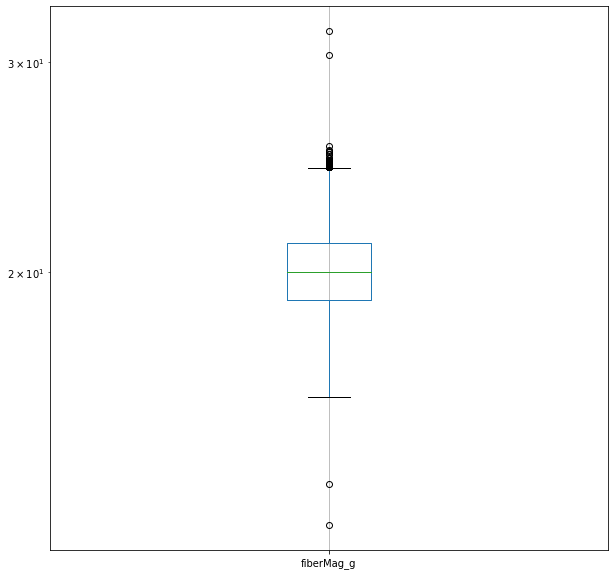

In [12]:
f, ax = plt.subplots(figsize=(10,10))
ax.set_yscale("log")
boxplot = train.boxplot(column=['fiberMag_g'])
#plt.yticks(np.arange())

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import minmax_scale
Scaler = StandardScaler()
#Scaler = MinMaxScaler()
#Scaler = RobustScaler()

train[['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i','fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i','petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']] = Scaler.fit_transform(train[['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i','psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i','fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i','petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i','modelMag_z']])

train.describe()
#train.info()
# numlist = train.columns
# numlist.drop(['id', 'type'])
# print(numlist)
# print("outlier제거 끝")
#ID별로 scaling
# pd.options.mode.chained_assignment = None
# for i in numlist:
#     if i != 'id' or i != 'type':
#       train.loc[i] = minmax_scale(train.loc[i], axis=0, copy=True)


,id,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,181911.000000,181911.000000,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05,1.819110e+05
mean,100419.584126,361.335703,4.017272e-16,-9.308503e-16,1.640589e-15,7.710841e-16,-9.386096e-16,3.176740e-15,1.796057e-16,1.022397e-15,-1.427021e-15,-2.389589e-15,6.383895e-18,-9.477613e-17,1.289272e-15,-1.971846e-15,-5.954577e-16,2.192747e-15,6.082482e-17,-6.624152e-16,-2.291125e-15,1.002590e-15
std,57458.360527,225.235758,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,0.000000,1.000000,-1.891822e+01,-2.637796e+00,-4.224959e+00,-3.000205e+00,-7.608644e+01,-6.938725e+00,-4.848370e+00,-3.019202e+00,-2.446403e+00,-5.676122e+00,-7.130019e-01,-1.142574e+02,-1.583964e+01,-2.332219e+01,-1.367411e+02,-9.209227e+00,-2.516241e+00,-2.650652e+00,-2.640587e+00,-2.636062e+00
25%,50727.500000,174.000000,-6.573128e-01,-6.374700e-01,-7.605258e-01,-7.258368e-01,-7.262438e-01,-6.436167e-01,-6.676195e-01,-7.653433e-01,-7.572322e-01,-7.625330e-01,-5.466464e-03,-7.018466e-01,-8.262410e-01,-8.413785e-01,-2.698238e-01,-6.890092e-01,-7.746629e-01,-8.422891e-01,-8.819483e-01,-8.730653e-01
50%,100391.000000,350.000000,-3.290335e-02,4.278845e-02,9.934718e-02,7.978286e-02,1.231498e-02,-4.248455e-02,1.806512e-05,6.300547e-02,2.404281e-02,-7.288568e-02,-2.948089e-03,8.353000e-03,8.057194e-02,8.435542e-03,-3.952519e-02,-1.228036e-01,1.763242e-02,9.256988e-02,2.386888e-02,-1.031335e-01
75%,150106.500000,527.000000,6.034206e-01,7.019913e-01,7.497414e-01,7.524541e-01,7.627094e-01,6.281430e-01,7.131120e-01,7.801092e-01,7.773874e-01,7.972785e-01,1.571991e-04,6.665776e-01,8.029584e-01,7.648172e-01,2.387953e-01,6.288313e-01,7.541515e-01,8.259560e-01,8.221737e-01,8.510109e-01
max,199990.000000,1000.000000,9.669007e+00,4.247851e+00,2.310456e+01,6.931582e+00,8.259837e+00,1.388137e+01,7.405746e+00,4.488600e+00,3.952310e+00,8.050780e+00,4.264987e+02,4.367998e+01,5.352430e+01,5.710169e+01,3.766464e+02,1.555323e+01,3.573564e+00,8.705537e+00,4.349670e+00,5.303493e+00


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181911 entries, 0 to 199990
Data columns (total 23 columns):
id            181911 non-null int64
type          181911 non-null object
fiberID       181911 non-null int64
psfMag_u      181911 non-null float64
psfMag_g      181911 non-null float64
psfMag_r      181911 non-null float64
psfMag_i      181911 non-null float64
psfMag_z      181911 non-null float64
fiberMag_u    181911 non-null float64
fiberMag_g    181911 non-null float64
fiberMag_r    181911 non-null float64
fiberMag_i    181911 non-null float64
fiberMag_z    181911 non-null float64
petroMag_u    181911 non-null float64
petroMag_g    181911 non-null float64
petroMag_r    181911 non-null float64
petroMag_i    181911 non-null float64
petroMag_z    181911 non-null float64
modelMag_u    181911 non-null float64
modelMag_g    181911 non-null float64
modelMag_r    181911 non-null float64
modelMag_i    181911 non-null float64
modelMag_z    181911 non-null float64
dtypes: float64(20),

In [0]:
# TRAIN 데이터의 TYPE을 SAMPLE_SUBMISSION에 대응하는 가변수 형태로 변환시킵니다.
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181911 entries, 0 to 199990
Data columns (total 24 columns):
id            181911 non-null int64
type          181911 non-null object
fiberID       181911 non-null int64
psfMag_u      181911 non-null float64
psfMag_g      181911 non-null float64
psfMag_r      181911 non-null float64
psfMag_i      181911 non-null float64
psfMag_z      181911 non-null float64
fiberMag_u    181911 non-null float64
fiberMag_g    181911 non-null float64
fiberMag_r    181911 non-null float64
fiberMag_i    181911 non-null float64
fiberMag_z    181911 non-null float64
petroMag_u    181911 non-null float64
petroMag_g    181911 non-null float64
petroMag_r    181911 non-null float64
petroMag_i    181911 non-null float64
petroMag_z    181911 non-null float64
modelMag_u    181911 non-null float64
modelMag_g    181911 non-null float64
modelMag_r    181911 non-null float64
modelMag_i    181911 non-null float64
modelMag_z    181911 non-null float64
type_num      181911

Text(0.5, 1.0, 'type Values in the Training Set - train()')

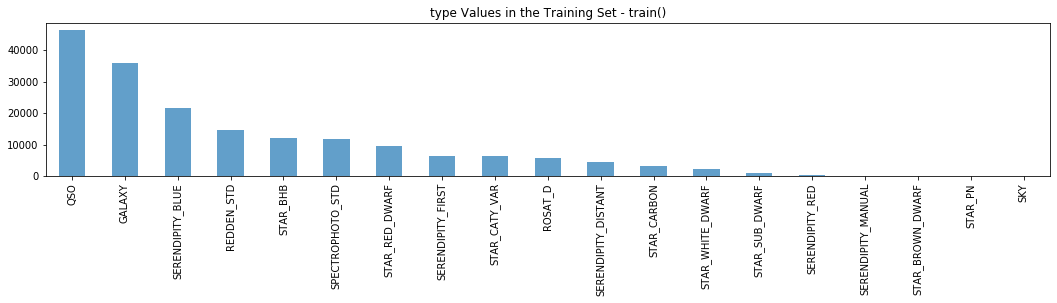

In [17]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=0.1)

plt.subplot2grid((3,3), (0,0), colspan=3)
train['type'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train()')

In [18]:
train['type'].value_counts()

QSO                    46355
GALAXY                 36062
SERENDIPITY_BLUE       21593
REDDEN_STD             14545
STAR_BHB               12078
SPECTROPHOTO_STD       11898
STAR_RED_DWARF          9671
SERENDIPITY_FIRST       6500
STAR_CATY_VAR           6222
ROSAT_D                 5800
SERENDIPITY_DISTANT     4455
STAR_CARBON             3125
STAR_WHITE_DWARF        2074
STAR_SUB_DWARF          1068
SERENDIPITY_RED          363
SERENDIPITY_MANUAL        50
STAR_BROWN_DWARF          37
STAR_PN                   13
SKY                        2
Name: type, dtype: int64

Class 간 차이가 많이 나므로, Undersampling 수행.
5천개 이상인것을 5천개만 Sampling 해서 수행.

In [19]:

print(sorted(Counter(train['type_num']).items()))
type0 = train[train['type_num']==1]
type1 = train[train['type_num']==4]
type2 = train[train['type_num']==5]
type3 = train[train['type_num']==6]
type4 = train[train['type_num']==8]
type5 = train[train['type_num']==10]
type6 = train[train['type_num']==11]
type7 = train[train['type_num']==13]
type8 = train[train['type_num']==15]
type9 = train[train['type_num']==18]
type10 = train[train['type_num']==0]
type11 = train[train['type_num']==2]
type12 = train[train['type_num']==3]
type13 = train[train['type_num']==7]
type14 = train[train['type_num']==9]
type15 = train[train['type_num']==12]
type16 = train[train['type_num']==14]
type17 = train[train['type_num']==16]
type18 = train[train['type_num']==17]
unsam_train0 = type0.sample(5000)
unsam_train1 = type1.sample(5000)
unsam_train2 = type2.sample(5000)
unsam_train3 = type3.sample(5000)
unsam_train4 = type4.sample(5000)
unsam_train5 = type5.sample(5000)
unsam_train6 = type6.sample(5000)
unsam_train7 = type7.sample(5000)
unsam_train8 = type8.sample(5000)
unsam_train9 = type9.sample(5000)
unsam_train = pd.concat([unsam_train0, unsam_train1, unsam_train2, unsam_train3, unsam_train4, unsam_train5, unsam_train6, unsam_train7, unsam_train8, unsam_train9, type10, type11, type12, type13, type14, type15, type16, type17, type18],axis=0)
print(sorted(Counter(unsam_train['type_num']).items()))


[(0, 2074), (1, 6222), (2, 37), (3, 363), (4, 14545), (5, 12078), (6, 36062), (7, 4455), (8, 46355), (9, 2), (10, 9671), (11, 5800), (12, 13), (13, 6500), (14, 3125), (15, 11898), (16, 1068), (17, 50), (18, 21593)]
[(0, 2074), (1, 5000), (2, 37), (3, 363), (4, 5000), (5, 5000), (6, 5000), (7, 4455), (8, 5000), (9, 2), (10, 5000), (11, 5000), (12, 13), (13, 5000), (14, 3125), (15, 5000), (16, 1068), (17, 50), (18, 5000)]


Text(0.5, 1.0, 'type Values in the Training Set - train()')

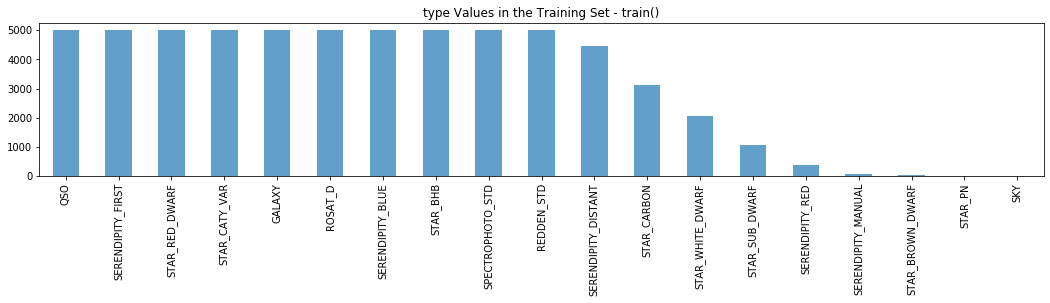

In [20]:
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=0.1)

plt.subplot2grid((3,3), (0,0), colspan=3)
unsam_train['type'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train()')

In [0]:
X_train = train.drop(columns=['type', 'type_num'])
y_train = train['type_num']

In [22]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 199991 to 209999
Data columns (total 19 columns):
STAR_WHITE_DWARF       10009 non-null float64
STAR_CATY_VAR          10009 non-null float64
STAR_BROWN_DWARF       10009 non-null float64
SERENDIPITY_RED        10009 non-null float64
REDDEN_STD             10009 non-null float64
STAR_BHB               10009 non-null float64
GALAXY                 10009 non-null float64
SERENDIPITY_DISTANT    10009 non-null float64
QSO                    10009 non-null float64
SKY                    10009 non-null float64
STAR_RED_DWARF         10009 non-null float64
ROSAT_D                10009 non-null float64
STAR_PN                10009 non-null float64
SERENDIPITY_FIRST      10009 non-null float64
STAR_CARBON            10009 non-null float64
SPECTROPHOTO_STD       10009 non-null float64
STAR_SUB_DWARF         10009 non-null float64
SERENDIPITY_MANUAL     10009 non-null float64
SERENDIPITY_BLUE       10009 non-null float64
dtypes: flo

In [23]:
sample_submission.describe()

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
count,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
AdaBoost = AdaBoostClassifier(n_estimators=400, random_state=1)


# for clf_name, clf in zip(['AdaBoost', 'GradientBoost'],[AdaBoost, GradientBoost]):
#     scores = cross_val_score(estimator= clf,
#                             X=X_train,
#                             y=y_train,
#                             cv=4,
#                             scoring='neg_log_loss')
#     print("ACCURACY : %f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), clf_name))

In [25]:
AdaBoost.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 400,
 'random_state': 1}

In [27]:
# from sklearn import metrics
# from sklearn.model_selection import train_test_split, GridSearchCV
# acc = metrics.make_scorer(metrics.accuracy_score)
# params={'learning_rate' : [0.01, 0.1],
#        'n_estimators' : [200, 500],
#        'base_estimator__max_depth' : [10,50]}
# clf = GridSearchCV(AdaBoost, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
# clf.fit(X_train, y_train)
# print('BestScore:{}'.format(clf.best_score_))
# print('BestParam:{}'.format(clf.best_params_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


KeyboardInterrupt: ignored

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
RANDOM_SEED = 0
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, \
                                                  test_size=0.2, random_state=RANDOM_SEED, stratify = y_train)
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=400,
                              algorithm="SAMME.R", learning_rate=0.5)

AdaBoost.fit(X_train, y_train)
Ada_pred = AdaBoost.predict_proba(test)
submission = pd.DataFrame(data=Ada_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('AdaboostClassifier3.csv', index=True)
submission.describe()

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
count,1.000900e+04,1.000900e+04,1.000900e+04,1.000900e+04,1.000900e+04,1.000900e+04,10009.000000,10009.000000,10009.000000,1.000900e+04,1.000900e+04,10009.000000,1.000900e+04,10009.000000,1.000900e+04,1.000900e+04,1.000900e+04,1.000900e+04,10009.000000
mean,2.442397e-06,9.707636e-08,1.194563e-06,5.891564e-05,8.632738e-10,1.487496e-07,0.007296,0.001349,0.799927,8.347541e-04,3.187459e-04,0.167617,7.032838e-08,0.021394,8.719824e-08,3.243327e-10,5.744367e-09,5.271463e-06,0.001195
std,6.569788e-07,4.090667e-08,4.389121e-07,2.374159e-05,1.029234e-09,3.111641e-07,0.002170,0.000651,0.040140,9.852013e-04,3.581529e-04,0.035404,2.285776e-08,0.005582,2.310628e-08,1.721304e-10,1.647595e-09,2.323160e-06,0.000354
min,6.984285e-07,2.483664e-08,5.861602e-08,4.614147e-07,4.689618e-10,7.030939e-08,0.000050,0.000167,0.559192,1.924551e-07,5.201990e-07,0.011619,1.168184e-08,0.000052,9.448016e-09,1.601811e-10,1.309082e-09,1.694220e-07,0.000236
25%,2.072587e-06,6.498744e-08,9.751809e-07,4.317997e-05,7.200262e-10,1.177577e-07,0.006320,0.000992,0.772789,2.786318e-04,6.689876e-05,0.153208,5.860429e-08,0.018381,7.436954e-08,2.263495e-10,4.738398e-09,3.638221e-06,0.001015
50%,2.363495e-06,8.298027e-08,1.162089e-06,5.720234e-05,7.647421e-10,1.284241e-07,0.007018,0.001292,0.794933,3.953957e-04,1.584100e-04,0.171108,6.755860e-08,0.021411,8.491124e-08,2.656329e-10,5.269246e-09,5.428433e-06,0.001255
75%,2.819787e-06,1.145219e-07,1.369885e-06,7.094262e-05,9.151150e-10,1.766576e-07,0.008145,0.001520,0.811260,9.411517e-04,3.962106e-04,0.189950,8.490739e-08,0.024920,9.876151e-08,4.115036e-10,6.236519e-09,7.253335e-06,0.001453
max,2.667429e-05,3.280099e-07,1.901288e-05,1.295669e-03,9.984015e-08,3.094900e-05,0.015302,0.004311,0.982631,7.152577e-03,2.984566e-03,0.377751,3.570201e-07,0.049006,5.481920e-07,1.106042e-08,6.262741e-08,8.853262e-05,0.010767


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 199991 to 209999
Data columns (total 19 columns):
STAR_WHITE_DWARF       10009 non-null float64
STAR_CATY_VAR          10009 non-null float64
STAR_BROWN_DWARF       10009 non-null float64
SERENDIPITY_RED        10009 non-null float64
REDDEN_STD             10009 non-null float64
STAR_BHB               10009 non-null float64
GALAXY                 10009 non-null float64
SERENDIPITY_DISTANT    10009 non-null float64
QSO                    10009 non-null float64
SKY                    10009 non-null float64
STAR_RED_DWARF         10009 non-null float64
ROSAT_D                10009 non-null float64
STAR_PN                10009 non-null float64
SERENDIPITY_FIRST      10009 non-null float64
STAR_CARBON            10009 non-null float64
SPECTROPHOTO_STD       10009 non-null float64
STAR_SUB_DWARF         10009 non-null float64
SERENDIPITY_MANUAL     10009 non-null float64
SERENDIPITY_BLUE       10009 non-null float64
dtypes: flo

,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
count,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0,10009.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
